In [14]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D,Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

In [15]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

In [16]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.3)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    print(noOfClasses,class_names, train_generator, validation_generator)
    
    return noOfClasses,class_names, train_generator, validation_generator

In [17]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [18]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.VGG16(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(modelInput.output)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel1(noOfClasses):
    modelInput = tf.keras.applications.VGG16(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    #x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [19]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
    ]
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'VGG16.keras', verbose=1, save_best_only=True)
    return model, annealer, checkpoint

In [20]:
def modelFit(model, annealer, checkpoint):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=gEpochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [21]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [22]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[7]*100
    TP = evl[1]
    FP = evl[2]
    FN = evl[4]
    TN = evl[3]
    prec = evl[5]
    rec = evl[6]
    F1 = 100 * ((2 * prec * rec) / (prec + rec))
    auc = evl[8]
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    msg+=f'\nTrue Positives = {TP}. True Negatives = {TN}'
    msg+=f'\nFalse Positives = {FP}. False Negatives = {FN}'
    msg+=f'\nPrecision = {prec}'
    msg+=f'\nRecall = {rec}'
    msg+=f'\nF1 Score = {F1}'
    msg+=f'\nROC AUC = {auc}'
    print(msg)

def saveModel(model, className):
    save_path = "/kaggle/working/" + className + " - VGG16.keras"
    model.save(save_path)
    print("Model saved at:", save_path)

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [24]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")
    def objective_function(hyperparameters):
        lr,batch = hyperparameters
        accuracy = accuracy_score(y_true,y_pred)
        return -accuracy
    
    accuracy = accuracy_score(y_true, y_pred)
    search_space = [(1e-4, 1e-2), (32, 256)]
    result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')
    best_hyperparameters = result.x
    print("Best Hyperparameters (learning rate, batch size):", best_hyperparameters)

In [25]:
mpath = r'/kaggle/input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
batchSize = 256
lr = 0.001

for i in classPaths:
    print(i)

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
5 ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi'] <keras.src.preprocessing.image.DirectoryIterator object at 0x794f642604c0> <keras.src.preprocessing.image.DirectoryIterator object at 0x794f64260400>
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928   

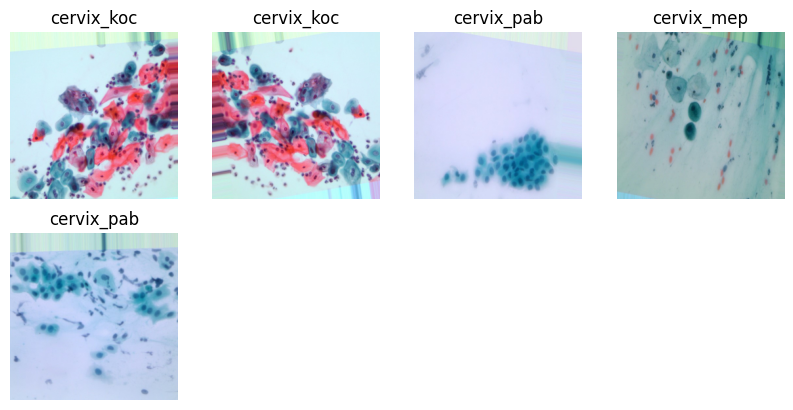

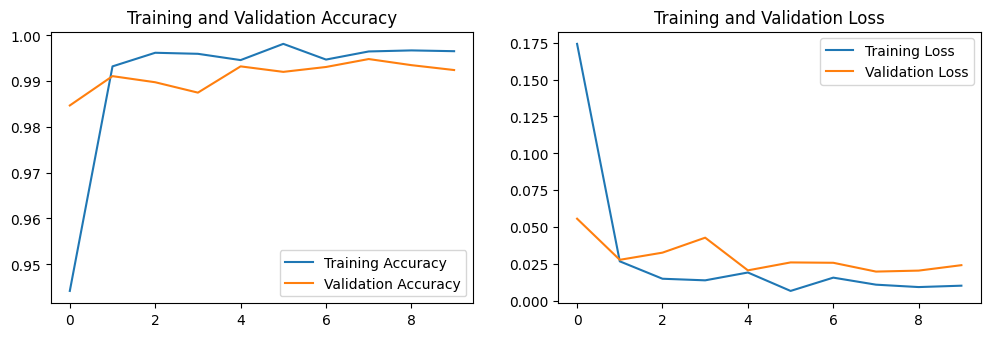

235/235 [==============================] - 25s 105ms/step - loss: 0.0240 - tp: 7442.0000 - fp: 53.0000 - tn: 29947.0000 - fn: 58.0000 - precision: 0.9929 - recall: 0.9923 - accuracy: 0.9924 - auc: 0.9995
Accuracy on the Test Set = 99.24 %
True Positives = 7442.0. True Negatives = 29947.0
False Positives = 53.0. False Negatives = 58.0
Precision = 0.9929286241531372
Recall = 0.9922666549682617
F1 Score = 99.25975291929169
ROC AUC = 0.9994966983795166
Model saved at: /kaggle/working/Cervical Cancer  - VGG16.keras
True :  [0 0 0 ... 4 4 4]
235/235 [==============================] - 23s 99ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

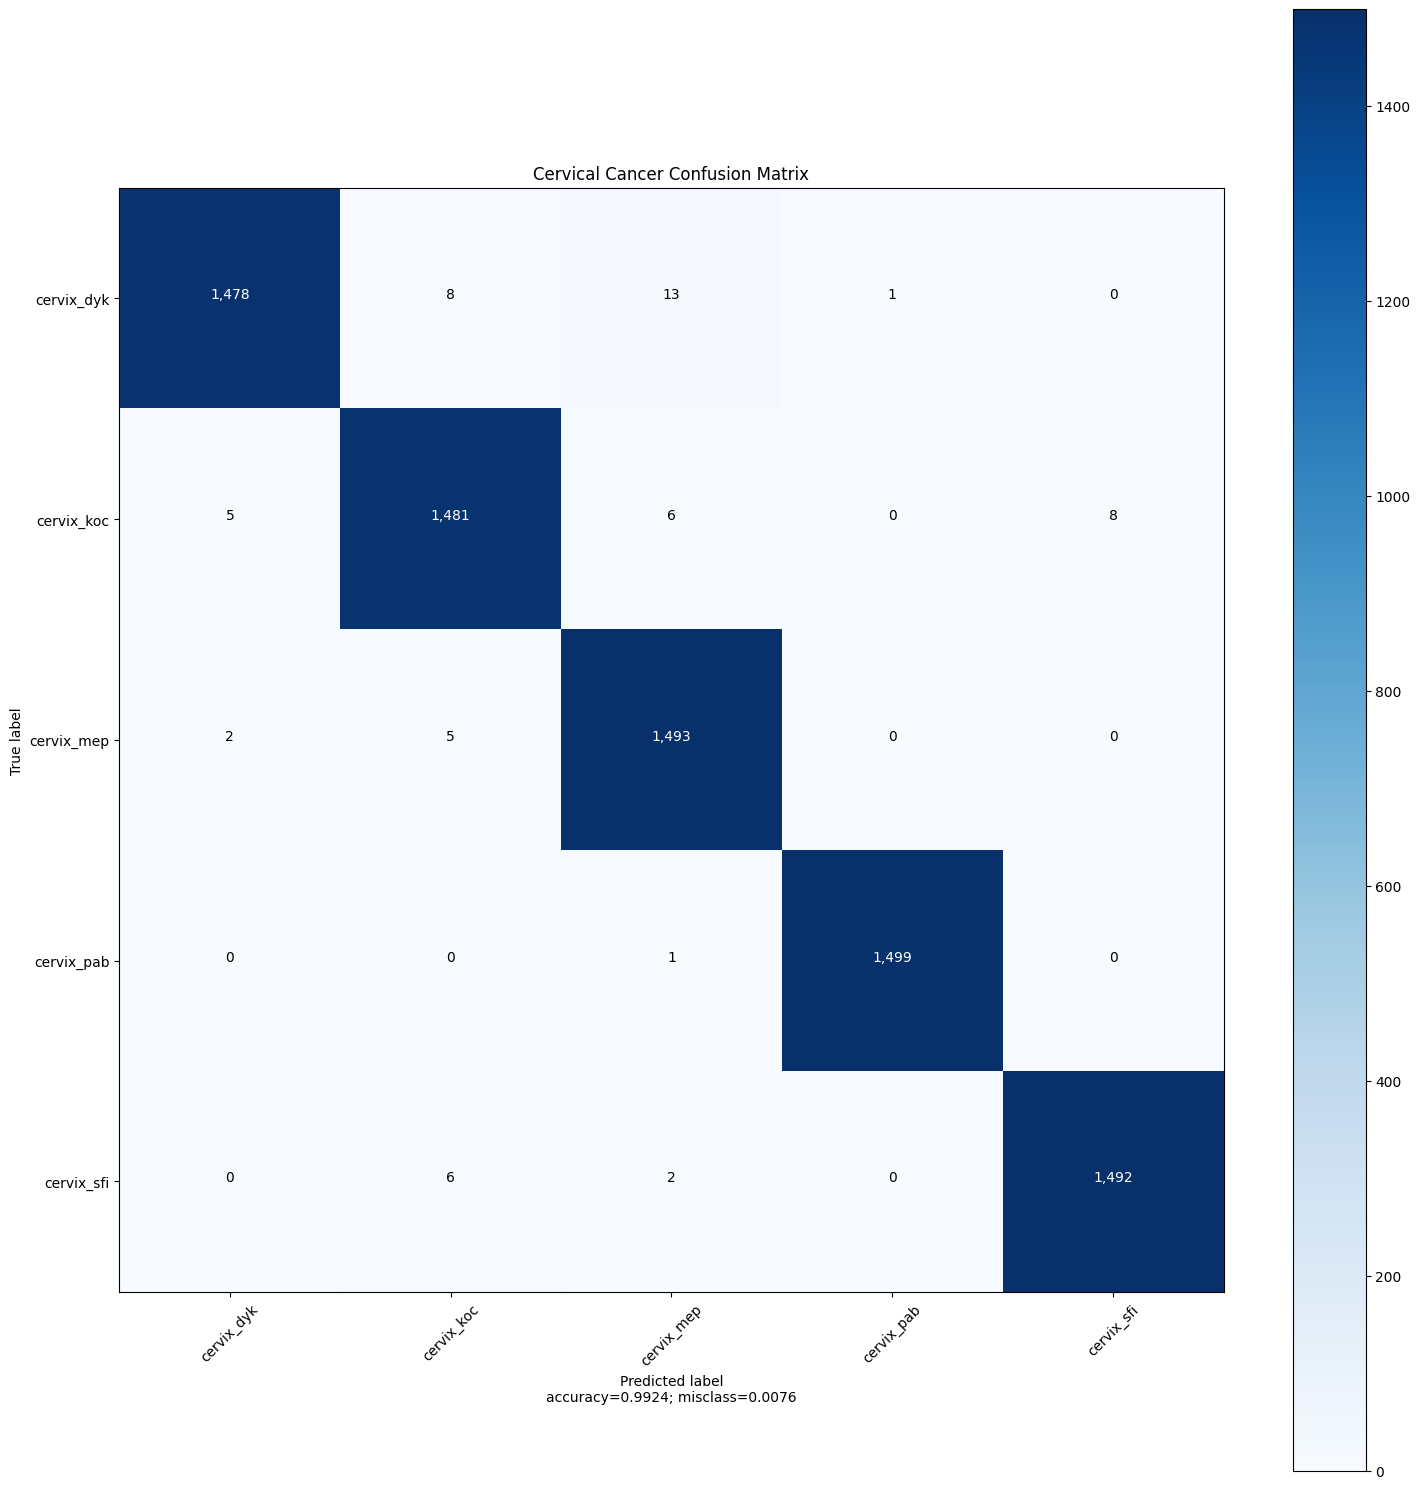

Best Hyperparameters (learning rate, batch size): [9.95284548e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [26]:
className = 'Cervical Cancer '
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
5 ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc'] <keras.src.preprocessing.image.DirectoryIterator object at 0x794b503ebb80> <keras.src.preprocessing.image.DirectoryIterator object at 0x794ff06e12d0>
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
             

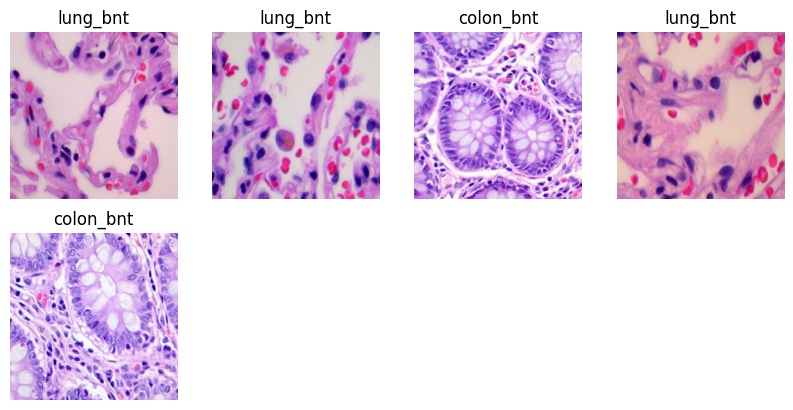

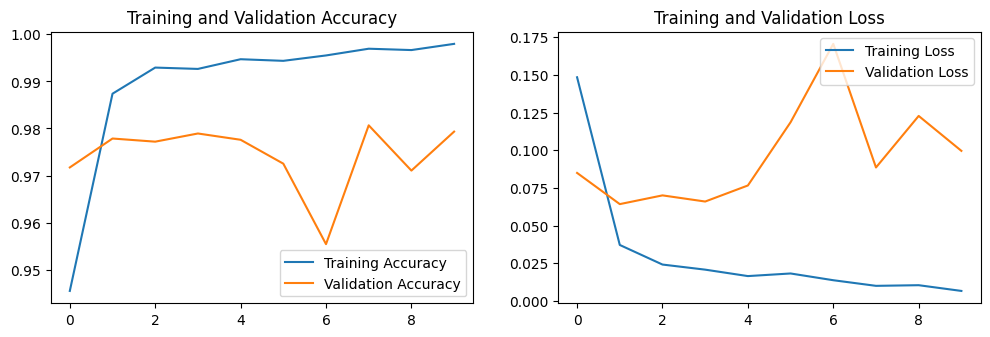

235/235 [==============================] - 26s 112ms/step - loss: 0.0995 - tp: 7343.0000 - fp: 152.0000 - tn: 29848.0000 - fn: 157.0000 - precision: 0.9797 - recall: 0.9791 - accuracy: 0.9793 - auc: 0.9966
Accuracy on the Test Set = 97.93 %
True Positives = 7343.0. True Negatives = 29848.0
False Positives = 152.0. False Negatives = 157.0
Precision = 0.9797198176383972
Recall = 0.9790666699409485
F1 Score = 97.9393134895233
ROC AUC = 0.9966374635696411
Model saved at: /kaggle/working/Lung and Colon Cancer  - VGG16.keras
True :  [0 0 0 ... 4 4 4]
235/235 [==============================] - 27s 115ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

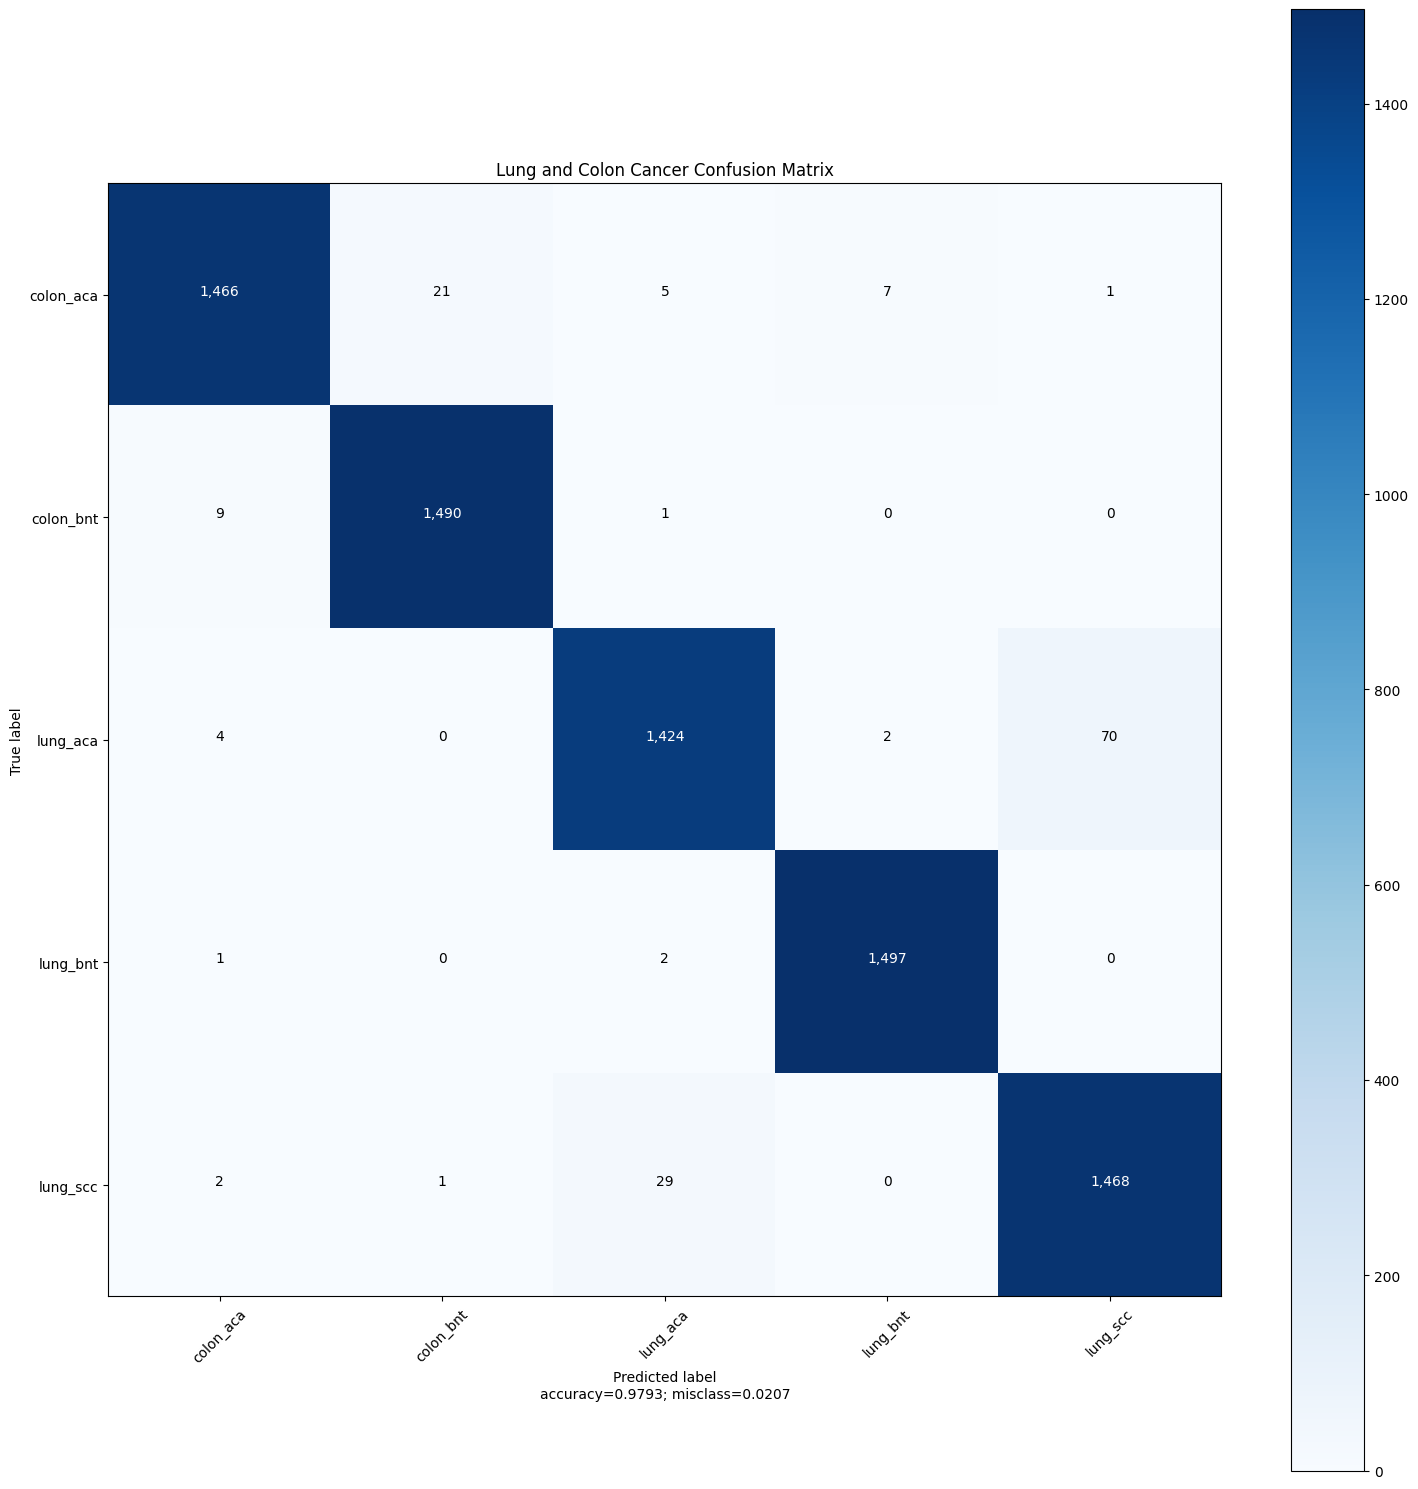

Best Hyperparameters (learning rate, batch size): [9.95284595e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [27]:
className = 'Lung and Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 7002 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
2 ['oral_normal', 'oral_scc'] <keras.src.preprocessing.image.DirectoryIterator object at 0x794f64239690> <keras.src.preprocessing.image.DirectoryIterator object at 0x794f64238190>
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxP

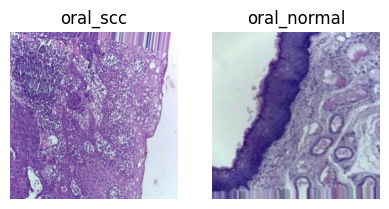

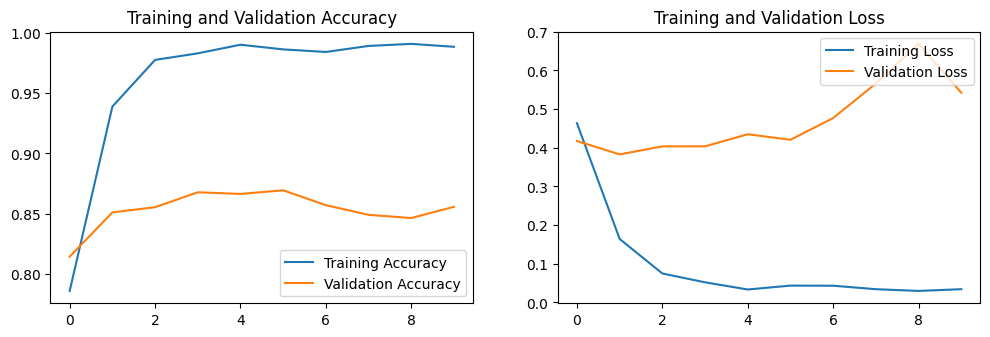

94/94 [==============================] - 10s 108ms/step - loss: 0.5420 - tp: 2567.0000 - fp: 433.0000 - tn: 2567.0000 - fn: 433.0000 - precision: 0.8557 - recall: 0.8557 - accuracy: 0.8557 - auc: 0.9273
Accuracy on the Test Set = 85.57 %
True Positives = 2567.0. True Negatives = 2567.0
False Positives = 433.0. False Negatives = 433.0
Precision = 0.8556666374206543
Recall = 0.8556666374206543
F1 Score = 85.56666374206543
ROC AUC = 0.9272770881652832
Model saved at: /kaggle/working/Oral Cancer  - VGG16.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 10s 106ms/step
Predicted :  [1 0 1 ... 0 1 0]


<Figure size 640x480 with 0 Axes>

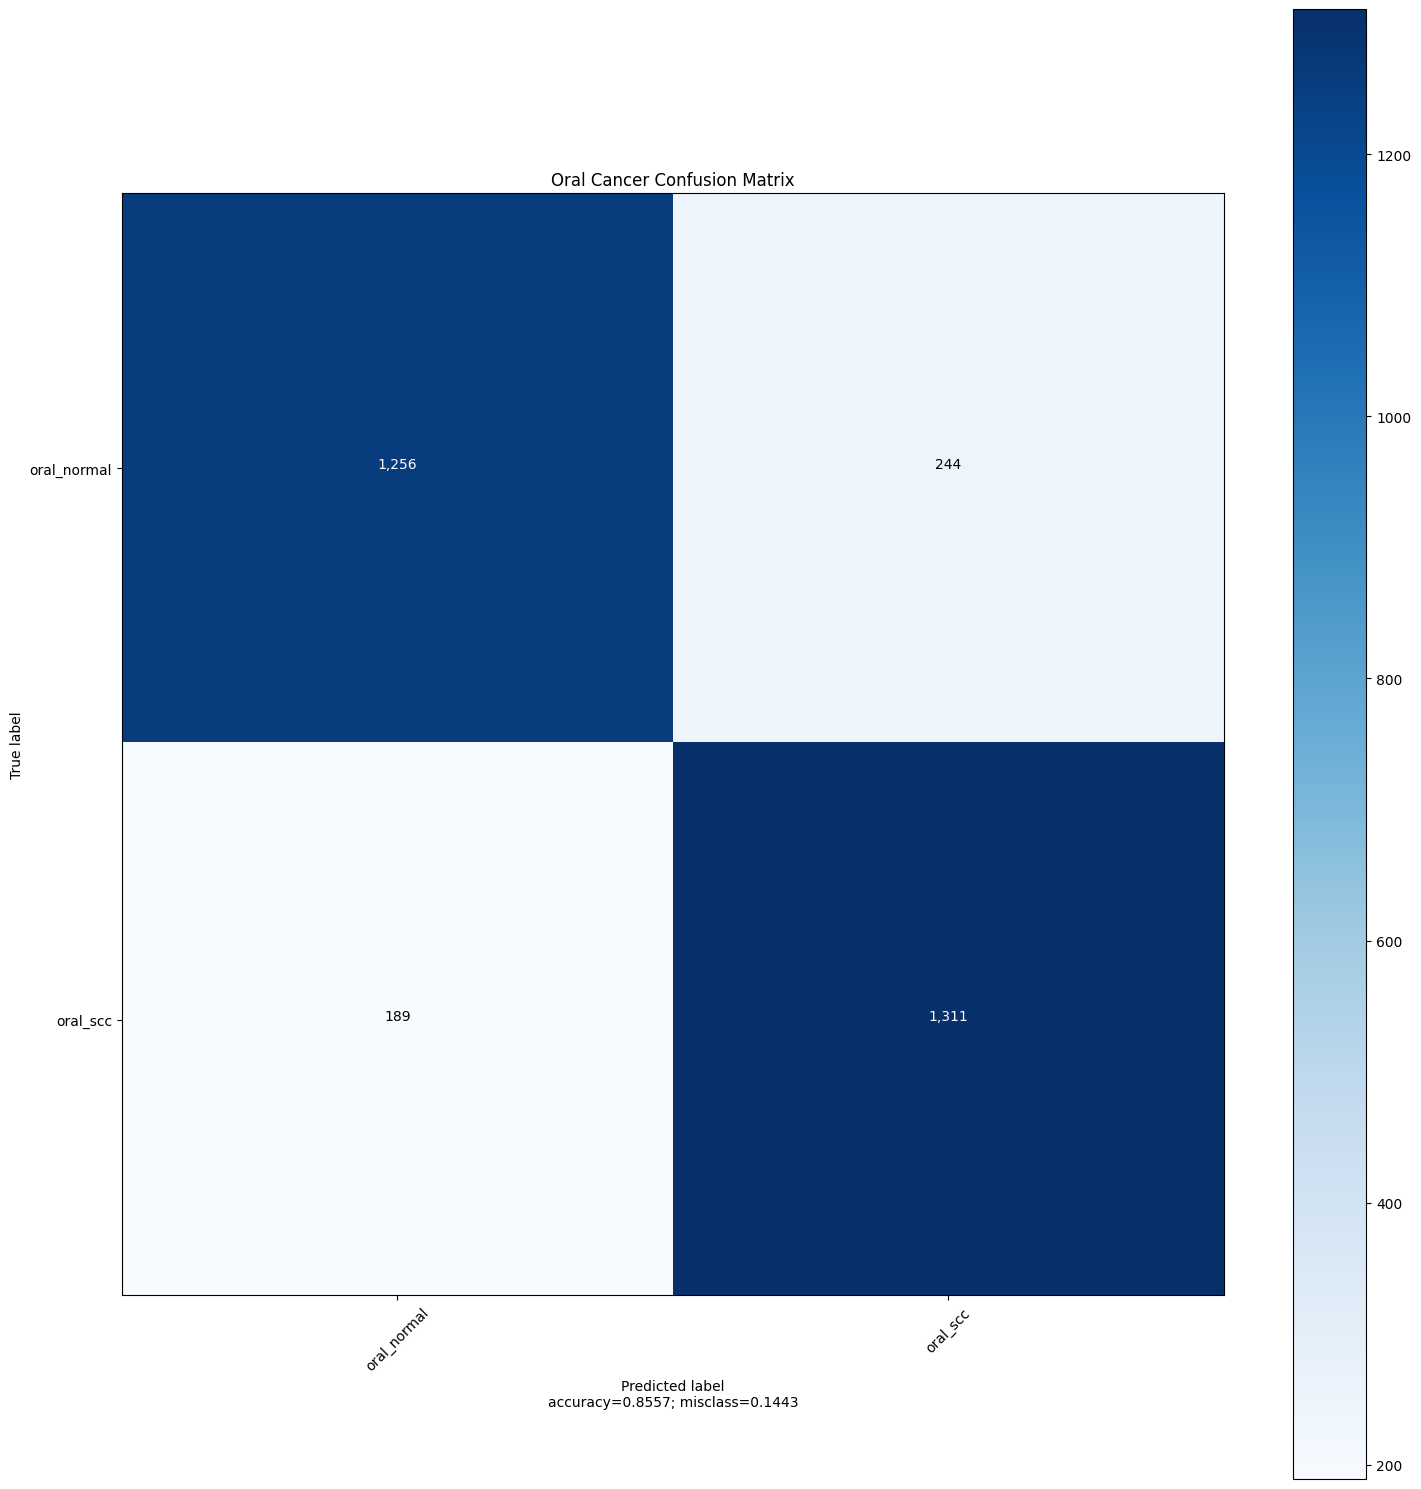

Best Hyperparameters (learning rate, batch size): [9.95285365e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [28]:
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 14000 images belonging to 4 classes.

For Val :  Found 6000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
4 ['all_benign', 'all_early', 'all_pre', 'all_pro'] <keras.src.preprocessing.image.DirectoryIterator object at 0x794b18919a20> <keras.src.preprocessing.image.DirectoryIterator object at 0x794f64226fe0>
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                       

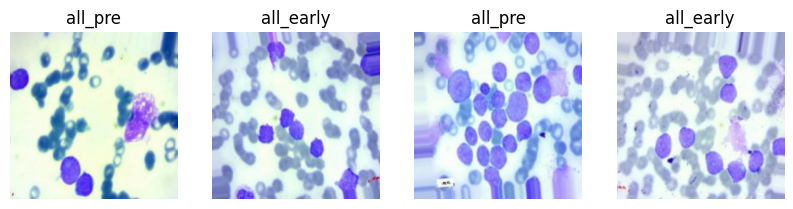

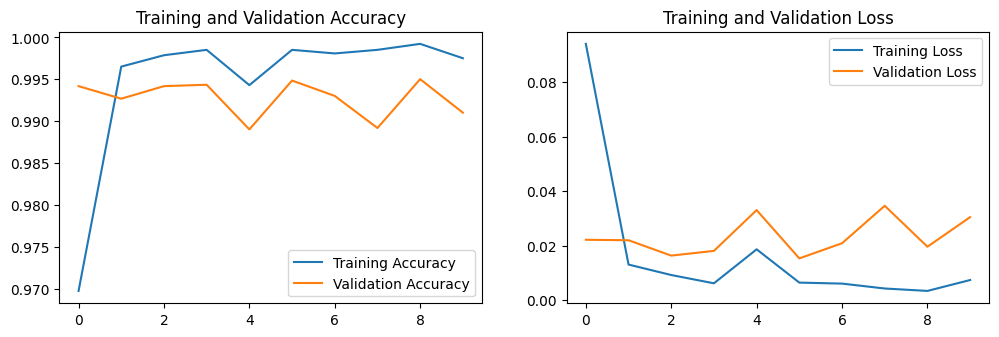

188/188 [==============================] - 19s 103ms/step - loss: 0.0305 - tp: 5946.0000 - fp: 53.0000 - tn: 17947.0000 - fn: 54.0000 - precision: 0.9912 - recall: 0.9910 - accuracy: 0.9910 - auc: 0.9989
Accuracy on the Test Set = 99.10 %
True Positives = 5946.0. True Negatives = 17947.0
False Positives = 53.0. False Negatives = 54.0
Precision = 0.9911652207374573
Recall = 0.9909999966621399
F1 Score = 99.10826018136433
ROC AUC = 0.9989370703697205
Model saved at: /kaggle/working/ALL  - VGG16.keras
True :  [0 0 0 ... 3 3 3]
188/188 [==============================] - 20s 103ms/step
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 640x480 with 0 Axes>

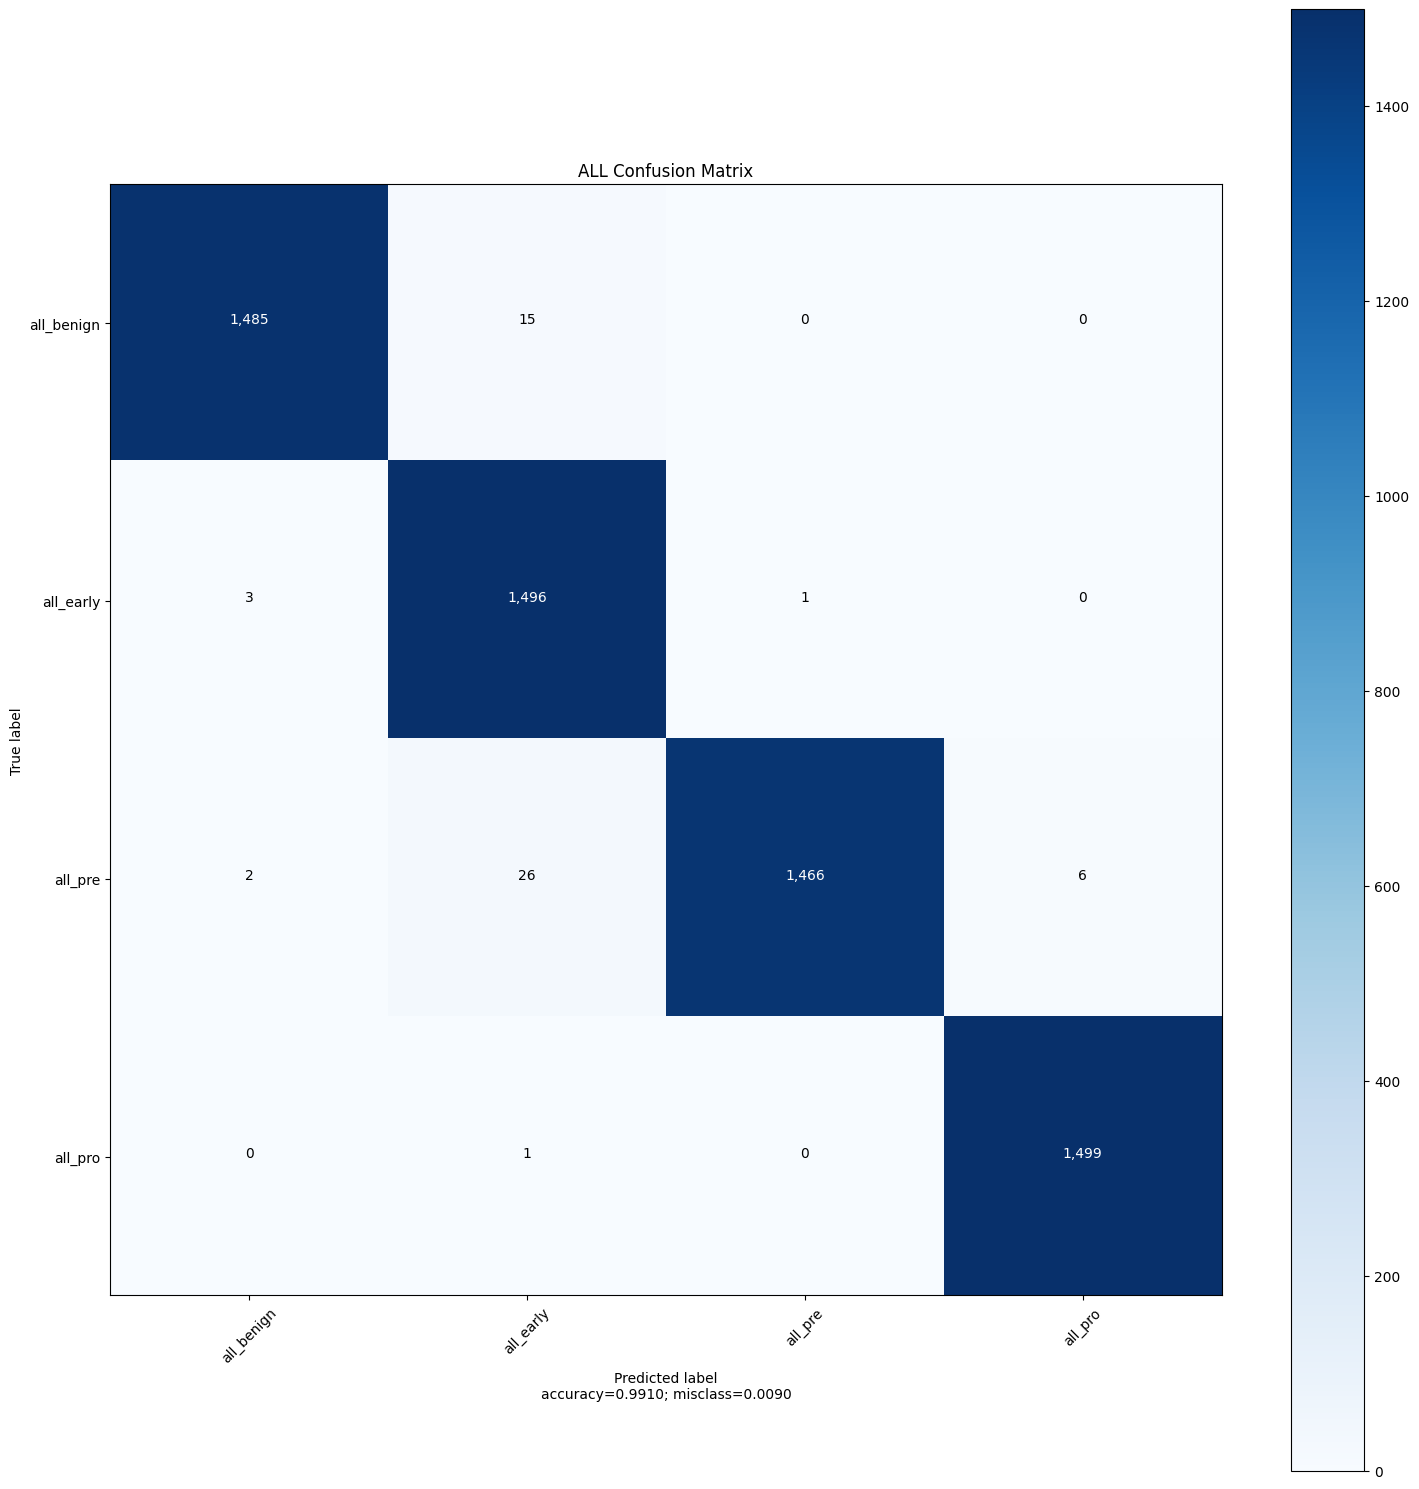

Best Hyperparameters (learning rate, batch size): [9.95285426e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [29]:
className = 'ALL '
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
2 ['kidney_normal', 'kidney_tumor'] <keras.src.preprocessing.image.DirectoryIterator object at 0x794b0b965240> <keras.src.preprocessing.image.DirectoryIterator object at 0x794b50578340>
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block

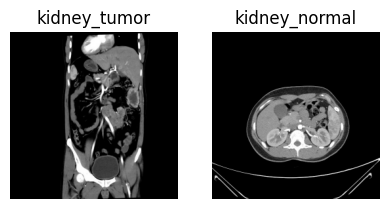

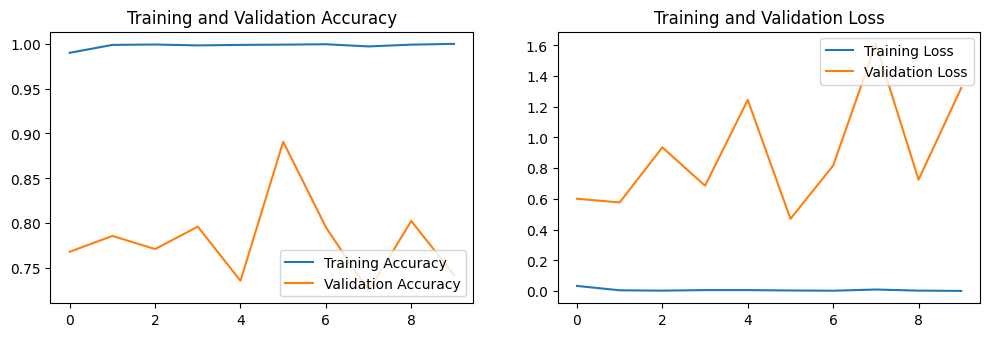

94/94 [==============================] - 9s 98ms/step - loss: 1.3222 - tp: 2226.0000 - fp: 774.0000 - tn: 2226.0000 - fn: 774.0000 - precision: 0.7420 - recall: 0.7420 - accuracy: 0.7420 - auc: 0.8324
Accuracy on the Test Set = 74.20 %
True Positives = 2226.0. True Negatives = 2226.0
False Positives = 774.0. False Negatives = 774.0
Precision = 0.7419999837875366
Recall = 0.7419999837875366
F1 Score = 74.19999837875366
ROC AUC = 0.8323842287063599
Model saved at: /kaggle/working/Kidney Cancer  - VGG16.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 9s 97ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

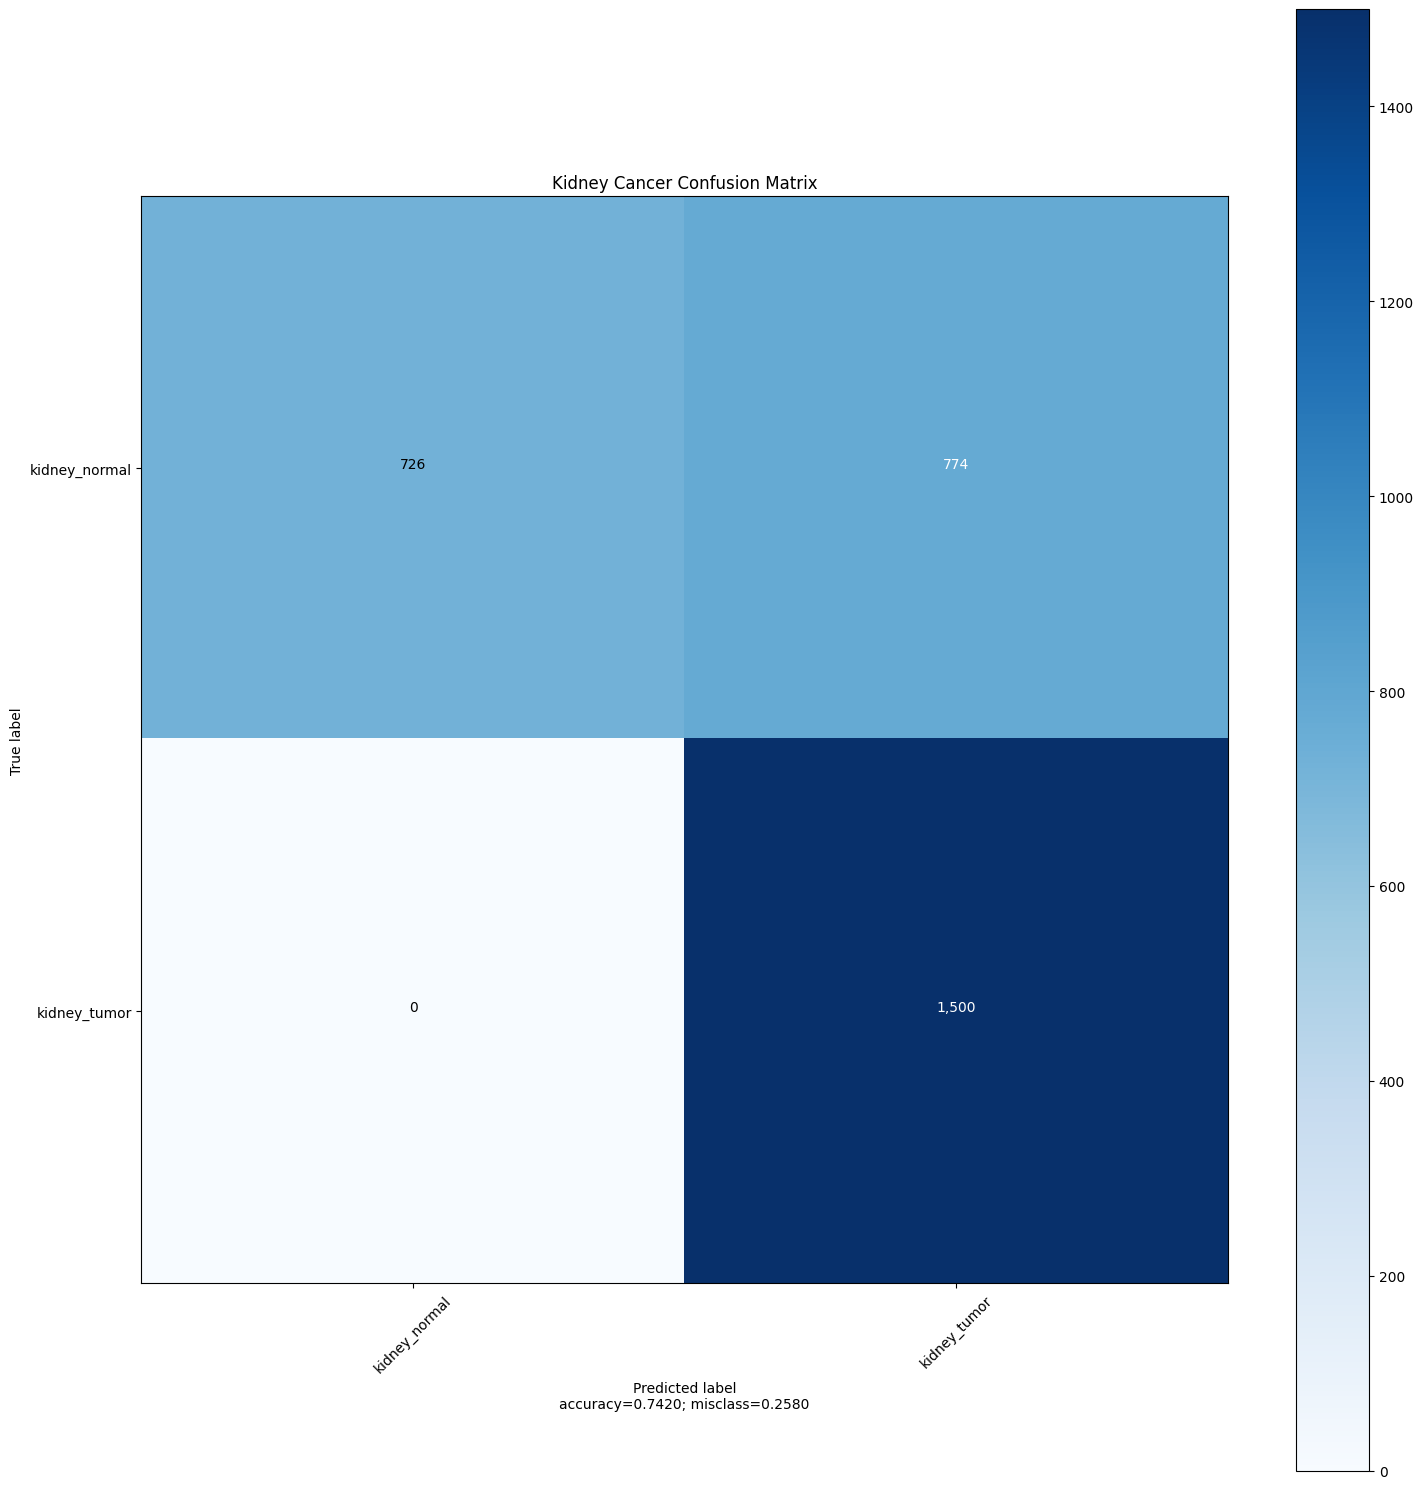

Best Hyperparameters (learning rate, batch size): [9.95284284e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [30]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
2 ['breast_benign', 'breast_malignant'] <keras.src.preprocessing.image.DirectoryIterator object at 0x794b08750a60> <keras.src.preprocessing.image.DirectoryIterator object at 0x794b0b947280>
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                

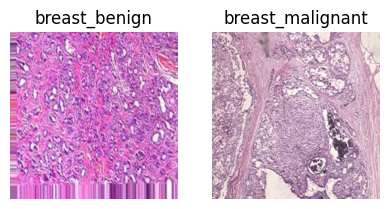

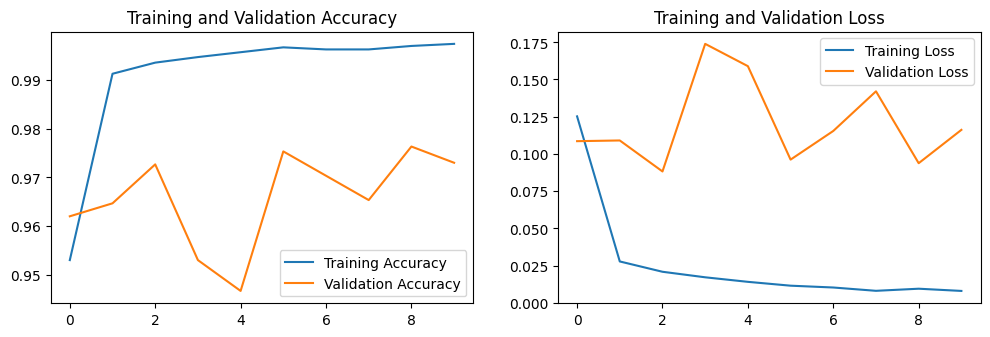

94/94 [==============================] - 23s 241ms/step - loss: 0.1162 - tp: 2919.0000 - fp: 81.0000 - tn: 2919.0000 - fn: 81.0000 - precision: 0.9730 - recall: 0.9730 - accuracy: 0.9730 - auc: 0.9910
Accuracy on the Test Set = 97.30 %
True Positives = 2919.0. True Negatives = 2919.0
False Positives = 81.0. False Negatives = 81.0
Precision = 0.9729999899864197
Recall = 0.9729999899864197
F1 Score = 97.29999899864197
ROC AUC = 0.9909683465957642
Model saved at: /kaggle/working/Breast Cancer  - VGG16.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 22s 236ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

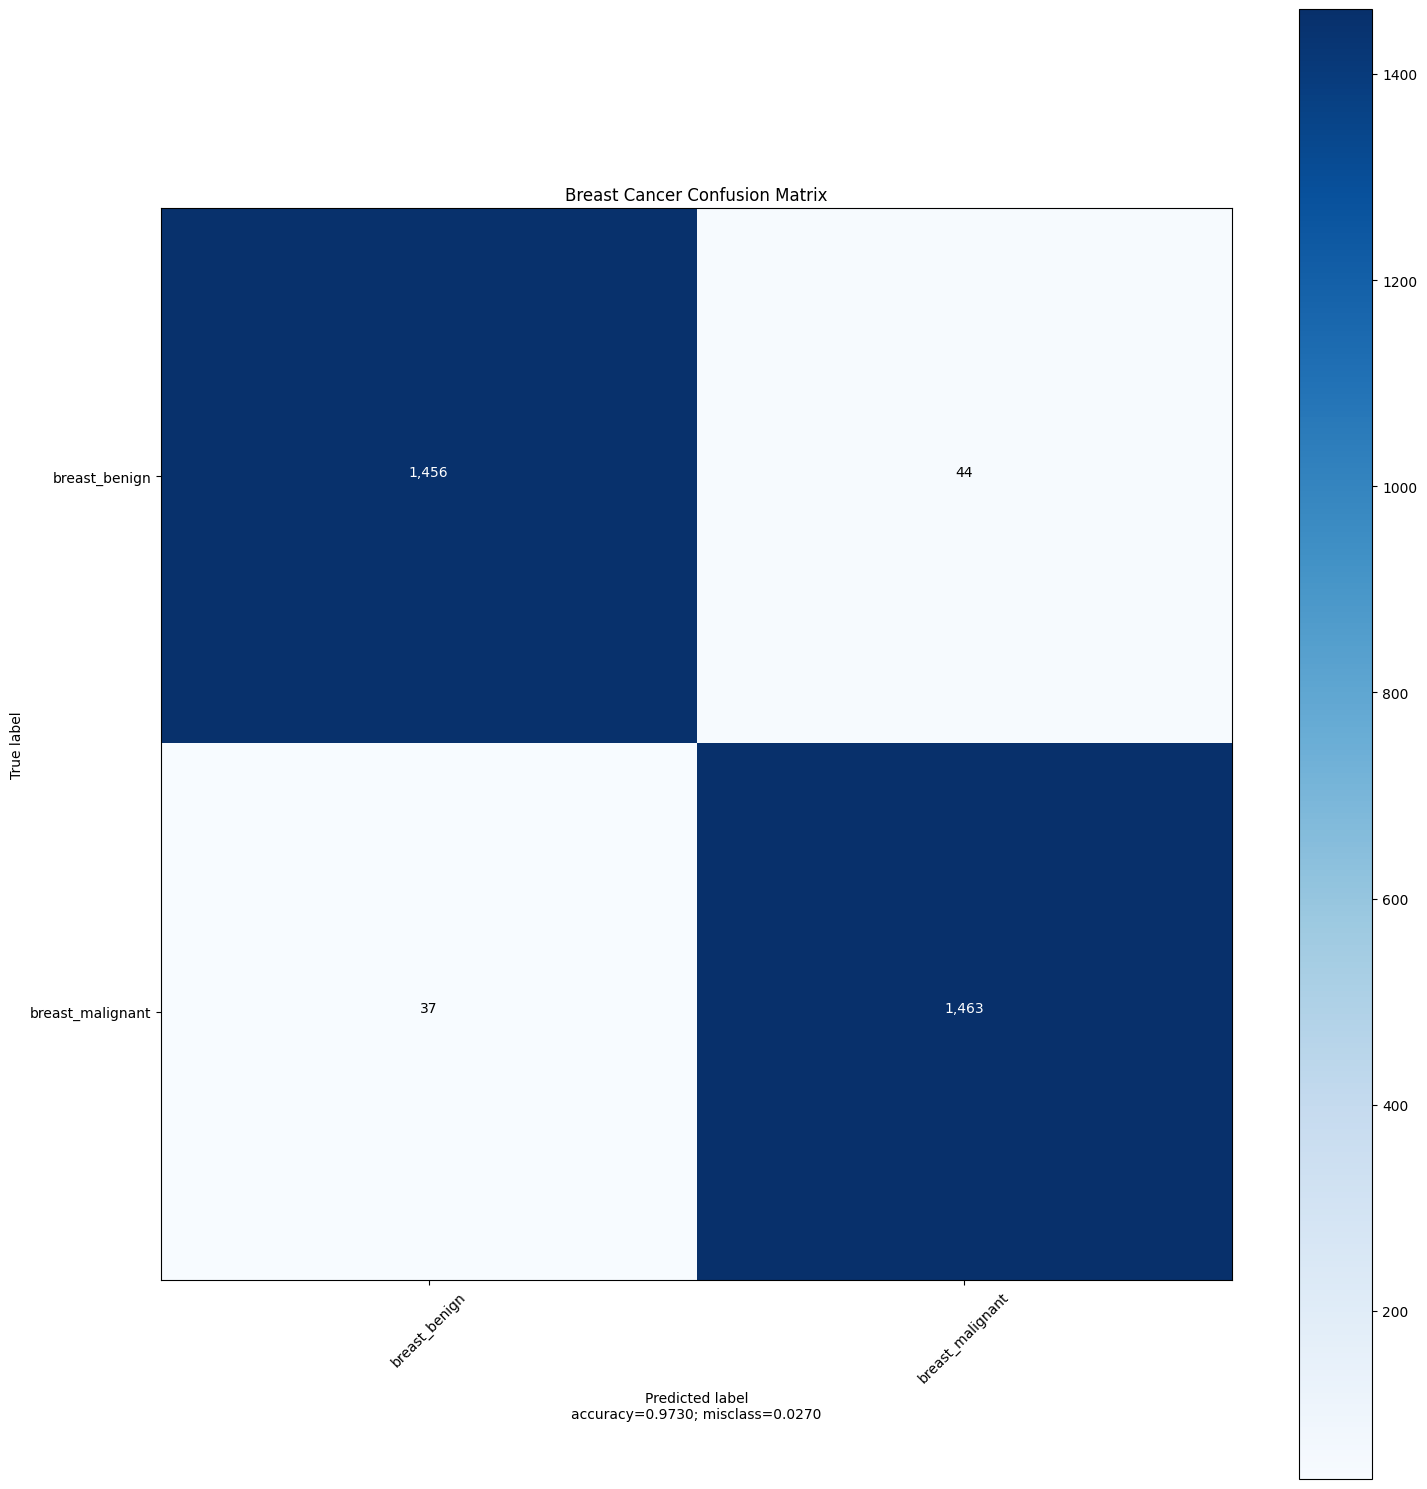

Best Hyperparameters (learning rate, batch size): [9.95285037e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [31]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
3 ['lymph_cll', 'lymph_fl', 'lymph_mcl'] <keras.src.preprocessing.image.DirectoryIterator object at 0x794b0b911030> <keras.src.preprocessing.image.DirectoryIterator object at 0x794fee1972b0>
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                             

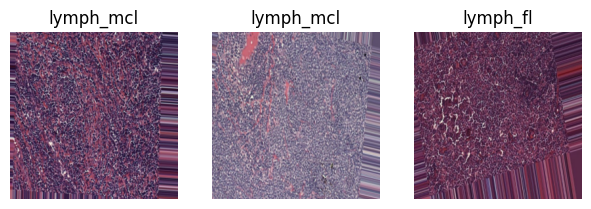

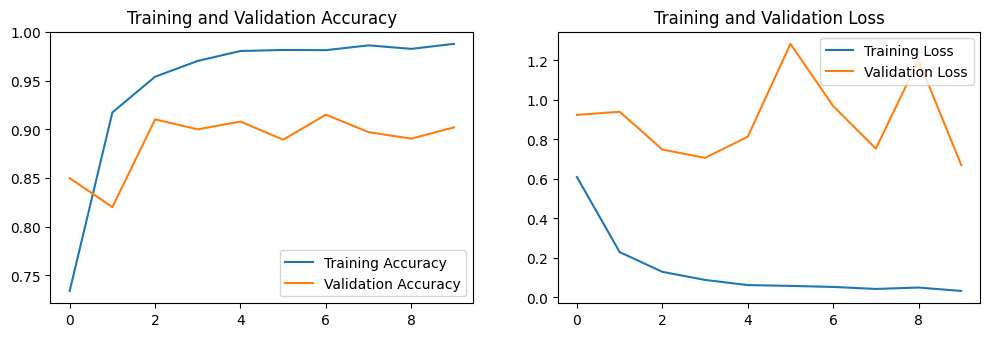

141/141 [==============================] - 19s 134ms/step - loss: 0.6698 - tp: 4053.0000 - fp: 429.0000 - tn: 8571.0000 - fn: 447.0000 - precision: 0.9043 - recall: 0.9007 - accuracy: 0.9020 - auc: 0.9729
Accuracy on the Test Set = 90.20 %
True Positives = 4053.0. True Negatives = 8571.0
False Positives = 429.0. False Negatives = 447.0
Precision = 0.9042838215827942
Recall = 0.9006666541099548
F1 Score = 90.24716133977532
ROC AUC = 0.9728831648826599
Model saved at: /kaggle/working/Lymphoma  - VGG16.keras
True :  [0 0 0 ... 2 2 2]
141/141 [==============================] - 18s 129ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

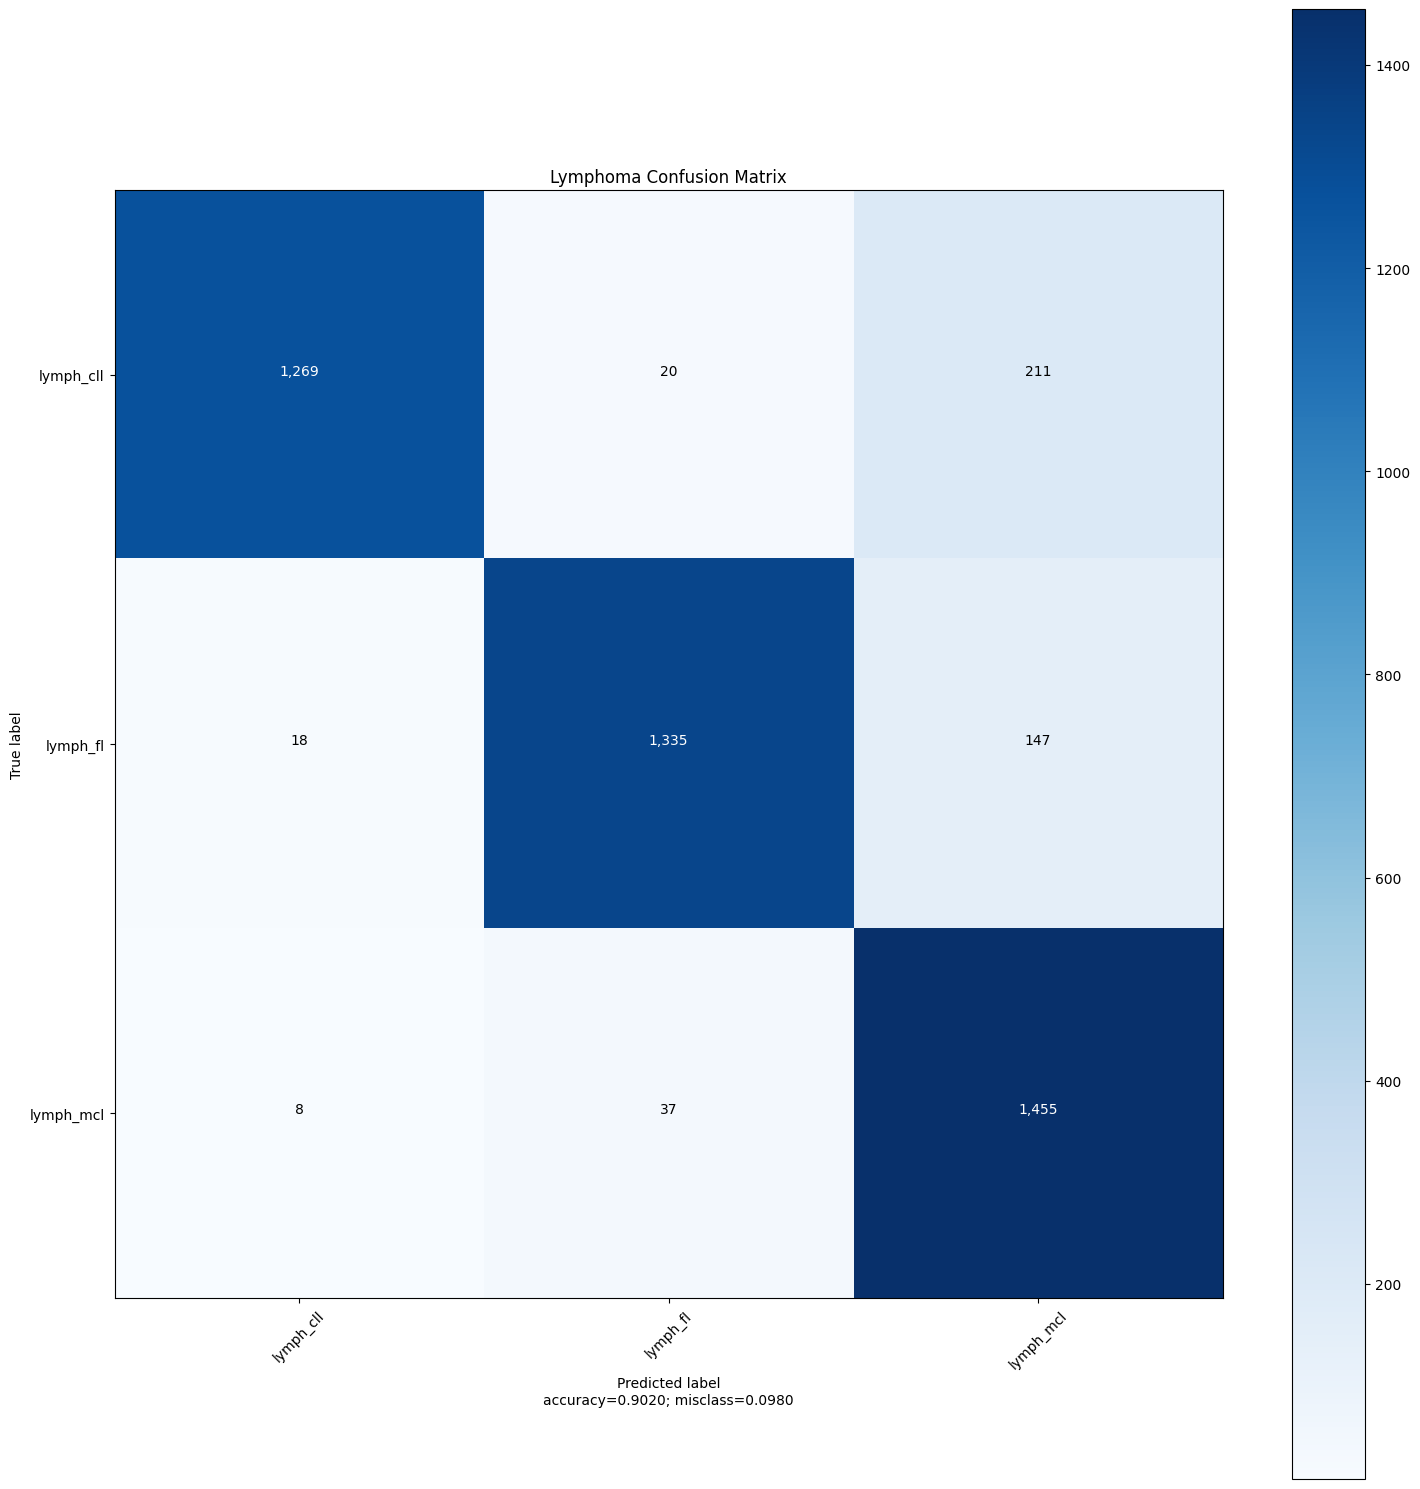

Best Hyperparameters (learning rate, batch size): [9.95285161e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [32]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
3 ['brain_glioma', 'brain_menin', 'brain_tumor'] <keras.src.preprocessing.image.DirectoryIterator object at 0x794f7c32e7d0> <keras.src.preprocessing.image.DirectoryIterator object at 0x794fec0ae530>
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                             

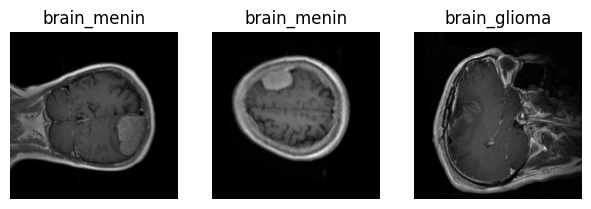

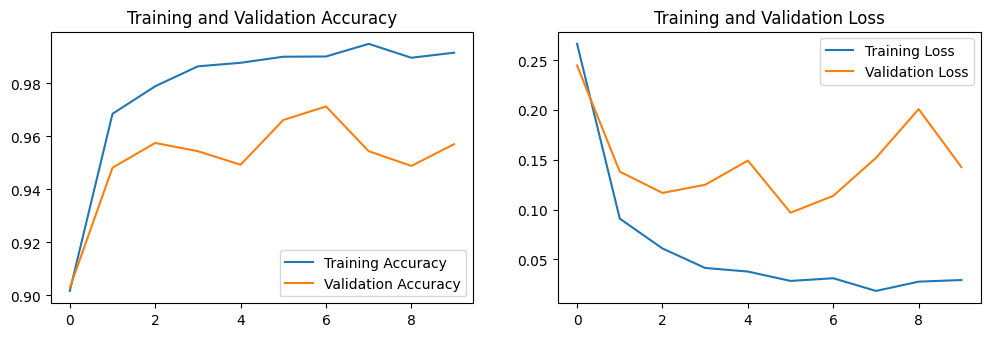

141/141 [==============================] - 13s 92ms/step - loss: 0.1427 - tp: 4303.0000 - fp: 192.0000 - tn: 8808.0000 - fn: 197.0000 - precision: 0.9573 - recall: 0.9562 - accuracy: 0.9571 - auc: 0.9939
Accuracy on the Test Set = 95.71 %
True Positives = 4303.0. True Negatives = 8808.0
False Positives = 192.0. False Negatives = 197.0
Precision = 0.9572858810424805
Recall = 0.9562222361564636
F1 Score = 95.67537629800196
ROC AUC = 0.993949294090271
Model saved at: /kaggle/working/Brain Cancer  - VGG16.keras
True :  [0 0 0 ... 2 2 2]
141/141 [==============================] - 13s 90ms/step
Predicted :  [0 1 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

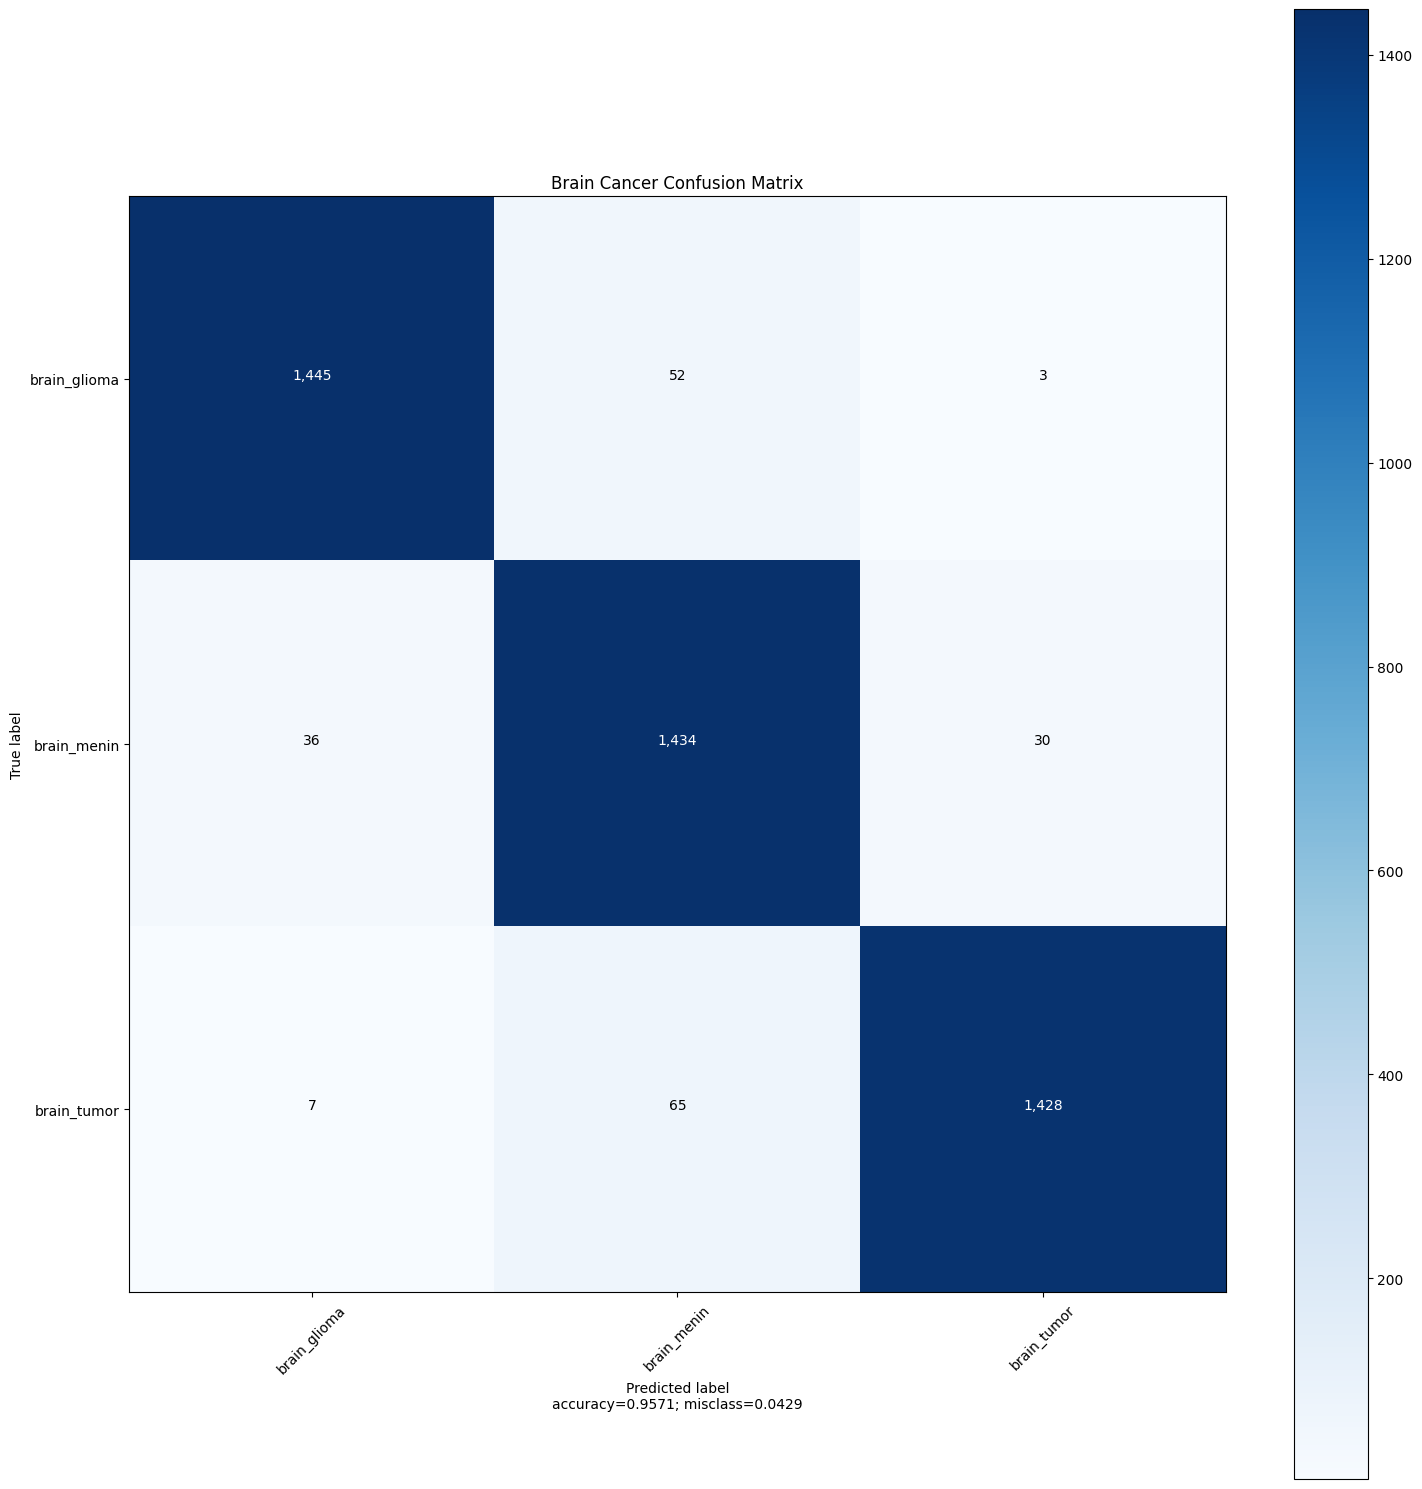

Best Hyperparameters (learning rate, batch size): [9.95285007e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [33]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)